# Ecological Data Science for Sustainable Agriculture (Part II)

## Imports

In [1]:
# Vector processing
import geopandas as gpd
import shapely
import osgb

# Raster processing
import rasterio
import rasterio.warp
import rasterio.mask
import rasterio.plot
import rasterio.features
import rasterio.sample
from rasterio import windows
import pyproj
import xarray as xr
import rioxarray

# Calcs and modelling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
from glob import glob
import warnings
import os
from pystac_client import Client
import boto3
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print
import subprocess
import functools
import sys
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

DATA_BASE_PATH = '../../../data/Agric_data/PoMS_Locations/' # all data under this path (global)
WORKING_CRS = 'EPSG:3035'


## Introduction

The UK is one of the most nature-depleted countries in the world, with a Biodiversity Intactness Index (BII) within the lowest fifth percentile of countries globally between 1970 and 2014 [1]. The BII is produced by the Natural History Museum in London and captures ecosystem intactness based on the PREDICTS database and an assessment of the impacts of anthropogenic pressures on species abundance and compositional similarity. The UK's standing marginally increased during this period to finish with the sixth lowest BII of any country globally.

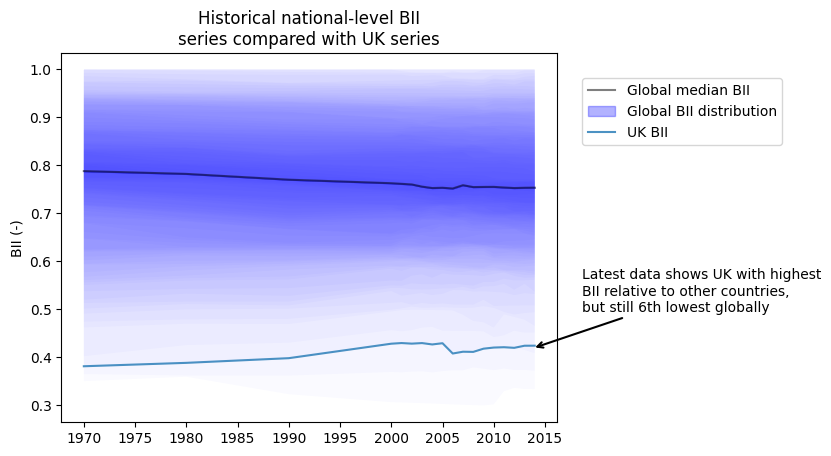

In [244]:
# Read in BII
bii = pd.read_json('../../../data/NHM_BII/resource.json').replace('NA', pd.NA).dropna(subset=['value', 'area_code'], how='any').astype({'value': float})
bii = bii[(bii['variable'] == 'bii') & (bii['scenario'] =='historical')]
bii['year'] = pd.to_datetime(bii['year'], format='%Y')

# Area code map
code_map_bii = pd.read_json('../../../data/NHM_BII/code_maps.json')[['value', 'label']]
code_map_bii['value'] = code_map_bii['value'].str.replace('.','-')
area_codes_bii = dict(code_map_bii.values)
bii['area'] = bii['area_code'].map(lambda x: area_codes_bii.get(x, pd.NA))
bii = bii[bii['area_code'].str.contains('[A-Za-z]')].dropna(subset=['area']) # countries only

# Rank
bii['year_rank_pct'] = 100.0*bii.groupby(['year'])['value'].rank('dense', pct=True)
bii['year_rank'] = bii.groupby(['year'])['value'].rank('dense')

def agg_gen_lower(j):
    return lambda x: np.quantile(x, j)

def agg_gen_upper(j):
    return lambda x: np.quantile(x, 1-j)

agg_funcs={'median': pd.NamedAgg(column='value', aggfunc=np.median)}
for i, j in enumerate(np.linspace(0,0.5, 50)):
    agg_funcs['lower_quantiles_{}'.format(i)] = pd.NamedAgg(column='value', aggfunc=agg_gen_lower(j))
    agg_funcs['upper_quantiles_{}'.format(i)] = pd.NamedAgg(column='value', aggfunc=agg_gen_upper(j))

summary_ts = bii.groupby('year')[['value']].agg(**agg_funcs).join(bii[bii['area_code'] == '001-150-154-GBR'].set_index('year')[['value']].rename(columns={'value': 'UK_BII'}))

plt.figure()
plt.plot(summary_ts.index, summary_ts['median'], color='k', alpha=0.5, label='Global median BII')
for i, j in enumerate(np.linspace(0,0.5, 50)):
    plt.fill_between(summary_ts.index, summary_ts['lower_quantiles_{}'.format(i)], summary_ts['upper_quantiles_{}'.format(i)],alpha=0.02, color='blue', edgecolor=None)

plt.fill_between(summary_ts.index, summary_ts['lower_quantiles_{}'.format(i)], summary_ts['upper_quantiles_{}'.format(i)],alpha=0.3, color='blue', label='Global BII distribution')
plt.plot(summary_ts.index, summary_ts['UK_BII'], alpha=0.8, label='UK BII')

plt.legend(loc=[1.05,0.75])
plt.ylabel('BII (-)')
plt.title('Historical national-level BII\nseries compared with UK series')
plt.annotate('Latest data shows UK with highest\nBII relative to other countries,\nbut still 6th lowest globally',xy=(0.95, 0.2),xytext=(1.05, 0.3), xycoords='axes fraction',
             arrowprops=dict(arrowstyle='->',lw=1.5))
plt.show()



Land used for agriculture accounted for 70% of the total area of the UK in 2023 [2]. The intensification of agriculture has, and continues to have negative consequences for biodiversity [3, 4]. Fertiliser inputs are often used to proxy agricultural intensity. Global application of inorganic nitrogen for agricultural use has increased by an order of magnitude in the last 60 years [5].

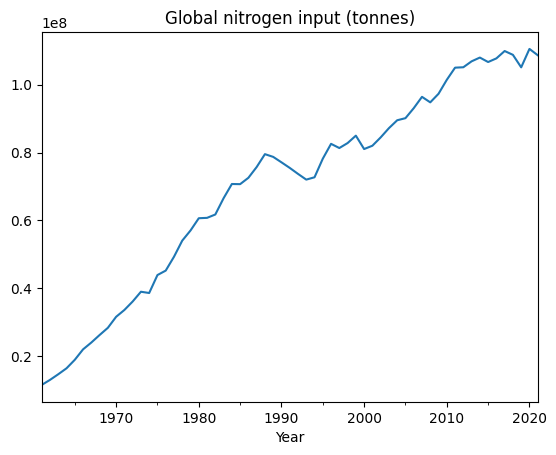

In [2]:
fert_series = pd.read_csv('../../../data/Agric_data/Global_fertiliser_input/FAOSTAT_data_en_2-20-2024.csv', parse_dates=['Year'])
fert_series.set_index('Year')[['Value']].plot(legend=False)
plt.title('Global nitrogen input (tonnes)')
plt.show()

Development of a cohesive high-level strategy on the intersection of biodiversity and agriculture can be aided by analysis of multi-scale datasets. This notebook, together with the next in the series, investigates applicability of a method linking remote sensing parameters with biodiversity data [6], to UK pollinator (UK PoMS) and plant monitoring (UK NPMS) survey data.

__Objectives__
1. Reproduce the method described in [6] from scratch in this Python-based notebook environment.
2. Extend that method such that it can be applied to PoMS samples.
3. Evaluate whether a significant correlation exists between remote sensing-derived parameters and PoMS biodiversity metrics.

## Methods

### Set datapoint used for demo graphs and maps

This is done retrospectively taking one of the directories generated in the subsequent download process.

In [246]:
location_code = 25
aoi_dir = 'location_{}'.format(location_code)
date = '2019_02_23'

### Biodiversity data: UK National Pollinator Monitoring Scheme

The UK Pollinator Monitoring Scheme (PoMS) [7], provides pan-trap records relating to systematic 1 km square surveys at 95 locations across the UK. The squares are visited four times per year for data collection. The UK PoMS is the only scheme in the world to conduct systematic pollinator survey data on pollinator species abundance at a national scale [8].

To align the methodology with [6], select a single year for analysis. Data for 2019 are used, as the sampling rate was highest for this year.

In [3]:
# Read in PoMS data
insect_data = gpd.read_file("../../../data/Agric_data/Pollinator/data/ukpoms_1kmpantrapdata_2017-2020_insects.csv")

# Set geometry
insect_data['X1km_centre'] = insect_data['X1km_square'].str[:4].str.cat(insect_data['X1km_square'].str[4:], sep='5') + '5' # X1km_square is the SW corner of the 1KM grid cell - so add 500m to centre the reference
insect_data['geometry'] = insect_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)

# Convert to an equal-area projection with units metres - so all the study areas have the same area
insect_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)

# Add geometries for study zones (now in working crs)
insect_data['study_zone'] = insect_data.geometry.buffer(2e3)
insect_data['study_zone_bbox'] = shapely.box(*np.split(insect_data['study_zone'].bounds.values, 4, axis=1)).flatten()

# Define study locations
insect_data = insect_data.astype({'location_code': int})
locations = insect_data.drop_duplicates('location_code').set_index('location_code')

# Convert types
insect_data['date'] = pd.to_datetime(insect_data['date'])
insect_data['count'] = insect_data['count'].astype(int)

# Select year
insect_data = insect_data[(insect_data['year'] == '2019')] # 2019 has the most records: insect_data.groupby('year')['count'].sum()

# Select England (no crop data for other nations in the UK)
insect_data = insect_data[insect_data['country'] == 'England']

insect_data.head(5)

,sample_id,country,location_code,location_name,X1km_square,date,year,pan_trap_station,occurrence_id,specimen_code,taxon_group,taxon_source,English_name,source_taxon_version_key,taxon_standardised,taxon_aggregated,count,sex,stage,comment,Order,Family,geometry,X1km_centre,study_zone,study_zone_bbox
5358,5641556,England,25,Conington,TL3266,2019-05-13,2019,1,12640765,3939,insect - hymenopteran,Lasioglossum puncticolle,Ridge-cheeked Furrow Bee,NHMSYS0000876203,Lasioglossum puncticolle,Lasioglossum puncticolle,1,female,adult,,Hymenoptera,Halictidae,POINT (3637007.773 3288593.600),TL325665,"POLYGON ((3639007.773 3288593.600, 3638998.143...","POLYGON ((3639007.773399447 3286593.600411404,..."
5359,5641566,England,25,Conington,TL3266,2019-05-13,2019,2,12640565,3941,insect - hymenopteran,Lasioglossum calceatum,Slender Mining Bee,NHMSYS0000876174,Lasioglossum calceatum,Lasioglossum calceatum,1,female,adult,,Hymenoptera,Halictidae,POINT (3637007.773 3288593.600),TL325665,"POLYGON ((3639007.773 3288593.600, 3638998.143...","POLYGON ((3639007.773399447 3286593.600411404,..."
5360,5641566,England,25,Conington,TL3266,2019-05-13,2019,2,12640566,3942,insect - hymenopteran,Lasioglossum malachurum,Sharp-collared Furrow Bee,NBNSYS0100003670,Lasioglossum malachurum,Lasioglossum malachurum,1,female,adult,,Hymenoptera,Halictidae,POINT (3637007.773 3288593.600),TL325665,"POLYGON ((3639007.773 3288593.600, 3638998.143...","POLYGON ((3639007.773399447 3286593.600411404,..."
5361,5641566,England,25,Conington,TL3266,2019-05-13,2019,2,12640567,3943,insect - hymenopteran,Lasioglossum calceatum,Slender Mining Bee,NHMSYS0000876174,Lasioglossum calceatum,Lasioglossum calceatum,1,female,adult,,Hymenoptera,Halictidae,POINT (3637007.773 3288593.600),TL325665,"POLYGON ((3639007.773 3288593.600, 3638998.143...","POLYGON ((3639007.773399447 3286593.600411404,..."
5362,5641566,England,25,Conington,TL3266,2019-05-13,2019,2,12640568,3944,insect - hymenopteran,Lasioglossum calceatum,Slender Mining Bee,NHMSYS0000876174,Lasioglossum calceatum,Lasioglossum calceatum,1,female,adult,,Hymenoptera,Halictidae,POINT (3637007.773 3288593.600),TL325665,"POLYGON ((3639007.773 3288593.600, 3638998.143...","POLYGON ((3639007.773399447 3286593.600411404,..."


Calculate biodiversity metrics for each location, pooling over sampling rounds, again to align with [6]:
- Species richness: the number of unique species observed
- Total abundance: sum of all individuals from all species

The sampling rate varied between locations. This is due to a varying number of location visits, and a varying number of pan traps used per visit. To ensure comparability across sampling locations, biodiversity metrics are scaled accordingly: abundance is scaled to the number of pan trap samples taken, and species richness is scaled according to a rarefaction function [9]. This produces expected biodiversity metrics based on a single pan-trap sample at each location.

In [4]:
def bee_hoverfly_metrics(group):
    '''Calculates PoMS biodiversity metrics (abundances and species richness).
    
    Includes adjustment for variable sampling rate at locations, correcting to 1-pantrap equivalent metrics.'''
    unique_species = group['taxon_aggregated'].unique()
    s_tot = len(unique_species) # number of unique species found at this location
    n = len(group.drop_duplicates(subset=['date', 'pan_trap_station'])) # number of sampling stations across dates (equal weight)
    n_i = group[['date', 'pan_trap_station', 'taxon_aggregated']].drop_duplicates()['taxon_aggregated'].value_counts() # number of sampling locations where each species is found 
    
    e_s_1 = (1.0 / n) * n_i.sum()  # expected species richness based on one pantrap station
    abundance_1 = len(group) *  (1.0 / n) # expected abundance based on one pantrap station
    
    return pd.Series({'abundance_1': abundance_1, 'species_richness_1': e_s_1})


bee_hoverfly_biodiversity = insect_data.groupby(['location_code']).apply(bee_hoverfly_metrics)

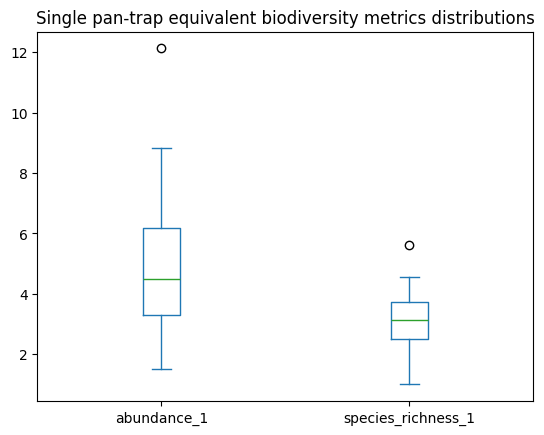

In [5]:
ax = bee_hoverfly_biodiversity.plot(kind='box')
ax.ticklabel_format(axis='y', style='plain')
plt.title('Single pan-trap equivalent biodiversity metrics distributions')

plt.show()


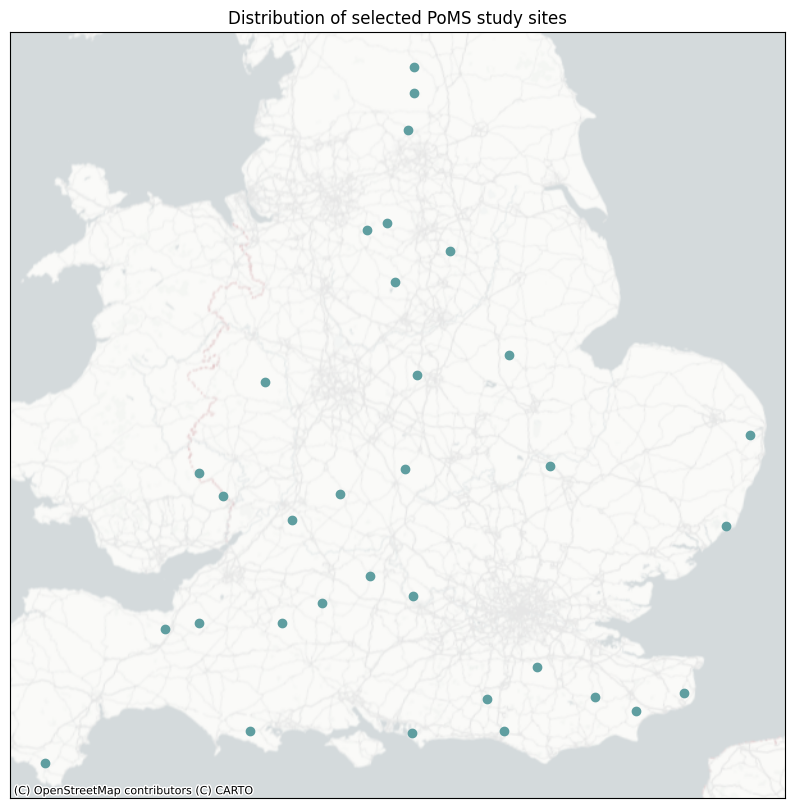

In [313]:
ax = insect_data.drop_duplicates('location_code').plot(figsize=(10, 10), edgecolor=None, color='cadetblue')
cx.add_basemap(ax, crs=insect_data.crs, source=cx.providers.CartoDB.PositronNoLabels)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Distribution of selected PoMS study sites')
plt.show()

### Agricultural land use data: CROME

Spring cereal fields were used for the study on which this notebook is based [6]. Here, the Crop Map of England (CROME) [10] was used to identify spring cereal fields based on agricultural land use codes. 

In [314]:
SPRING_CEREAL_LUCODES = ['AC01', # barley
                         'AC19', # oats
                         'AC24', # rye
                         'AC30', # triticale
                         'AC32'] # wheat


For the purposes of estimating agricultural intensity in the vicinity of each sampling location, I consider a circle of radius 2km centred on the sampling location. 

This represents an adaptation of the methodology described in [6], which analyses only the four Sentinel-2 pixels at the centre of each field used for biodiversity surveys. Implementing such a constraint on the PoMS dataset cuts the sample size significantly. Given that pollinators are relatively mobile, a larger study area was chosen here; honey bees regularly travel the chosen radius (2km) to forage, and have been observed as far as 10km from the hive [11].

An example study location (with surrounding CROME spring cereal cells) is shown below; CROME data is published on a hex grid (resolution ~40m side length).

Note that the CROME data for each of these locations is downloaded outside of this script, see https://github.com/twhit1/quant_ecolo/blob/dev/docs/get_crome_2019.sh.


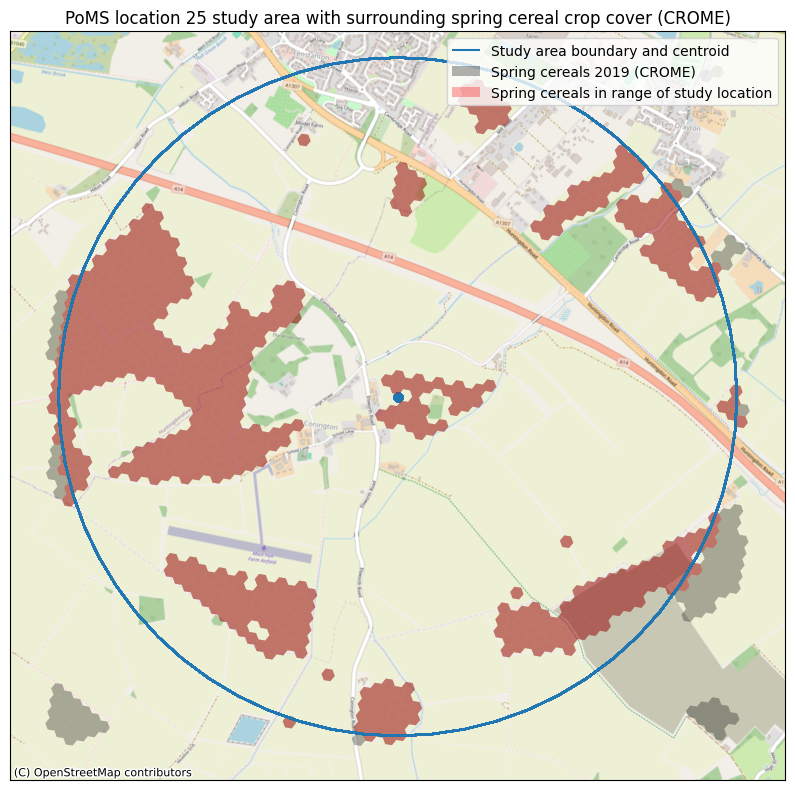

In [19]:

location_path = f'../../../data/Agric_data/PoMS_Locations/{aoi_dir}/CROME'

crome_data = gpd.read_file(location_path).to_crs(insect_data.crs)
    
# filter for spring cereals
crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]
sc_cells_in_radius = crome_data[crome_data.intersects(insect_data[insect_data['location_code'] == location_code]['study_zone'].iloc[0])]

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
crome_data.plot(ax=ax, color='k', alpha=0.3, edgecolor=None)
cx.add_basemap(ax, crs=insect_data.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

insect_data[insect_data['location_code'] == location_code]['geometry'].plot(ax=ax)
insect_data[insect_data['location_code'] == location_code]['study_zone'].exterior.plot(ax=ax, label='Study area boundary and centroid')
sc_cells_in_radius.plot(ax=ax, color='red', alpha=0.3, label='Spring cereals in range of study location')

legend_handles = [mpl.patches.Patch(facecolor='k', alpha=0.3, label=f"Spring cereals 2019 (CROME)"),
                  mpl.patches.Patch(facecolor='r', alpha=0.3, label="Spring cereals in range of study location")]

plt.legend(handles=ax.get_legend_handles_labels()[0] +  legend_handles)

ax.set_xticks([])
ax.set_yticks([])

plt.title('PoMS location {} study area with surrounding spring cereal crop cover (CROME)'.format(location_code))
plt.show()



### Download Sentinel-2 imagery

For each PoMS location, the 2019 timeseries of Sentinel-2 crops (thematic maps, visual and vegetation index inputs) is downloaded.

Expand the cell below to see the methodology.

In [ ]:
def get_pystack_aws_sessions():
    '''Initiates a pystac client and rasterio AWS session to coordinate requests.'''
    client = Client.open("https://earth-search.aws.element84.com/v1")
    aws_session = rasterio.session.AWSSession(boto3.Session(), requester_pays=True)

    return client, aws_session

def read_S3(href, aoi_bbox_geodetic):
    '''Downloads the data and metadata corresponding to an acquisition, based on a 
    reference and spatial filter (defined as a shapely bbox in EPSG:4326).'''
    with rasterio.open(href) as src:
        # Transform window to src crs
        transform_geodetic_to_s2 = pyproj.Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        src_bbox = shapely.ops.transform(transform_geodetic_to_s2, aoi_bbox_geodetic)
        window = rasterio.windows.from_bounds(*conform_bbox(src_bbox),
                                              transform=src.transform).round_lengths()
        data = src.read(window=window) 
        src_profile = src.profile
        src_profile.update({'width': window.width,
                            'height': window.height,
                            'transform': rasterio.windows.transform(window, src.transform)})

    return {'data': data, 'profile': src_profile}
    
def get_geodetic_bbox(bbox, bbox_crs):
    '''Transforms a bounding box (as a shapely box) in a given CRS to EPSG:4326'''
    # Get transformer for bbox
    transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(bbox_crs), 
                                                                pyproj.CRS('EPSG:4326'), 
                                                                always_xy=True).transform
    # Get transformed bbox (in EPSG:4326)
    bbox_geodetic_coords = transform_working_to_geodetic(*bbox.exterior.xy)
    bbox_geodetic = shapely.geometry.Polygon(np.stack(bbox_geodetic_coords, axis=1))

    return bbox_geodetic

def conform_bbox(shapely_bbox):
    '''Returns coords as left, bottom, right, top from a shapely box.
    
    This is a utility function to go between shapely and (rasterio and pystac)'''
    shapely_bbox_coords = shapely_bbox.exterior.coords.xy
    rio_stac_bbox_coords = [min(shapely_bbox_coords[0]), # Align shapely and pystac conventions
                             min(shapely_bbox_coords[1]), 
                             max(shapely_bbox_coords[0]), 
                             max(shapely_bbox_coords[1])]
            
    return rio_stac_bbox_coords
    
def search_stac(client, aoi_bbox_geodetic=None, datetime=None, max_items=1000, query=None):
    '''searchs a stac collection with using client, filtering based on aoi_bbox_geodetic
    (a shapely box in EPSG:4326), and based on datetime. See pystac docs for client.search 
    API details.

    Note that pystac client expands datetimes, i.e. from the docs "2017 
    expands to 2017-01-01T00:00:00Z/2017-12-31T23:59:59Z".
    
    query examples:
      filter on processing baseline (see https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/processing-baseline)
        query = {'s2:processing_baseline': {"neq": "05.00"}}

      filter on cloud cloverage
        query=['eo:cloud_cover<50']
    ''' 
    search = client.search(max_items=max_items, # speed up
                           collections=['sentinel-2-l2a'],
                           query=query,
                           bbox=conform_bbox(aoi_bbox_geodetic),
                           datetime=datetime)

    if search.matched() == max_items:
        distributed_print('Did not receive complete results. Consider increasing max_items kwarg ' + \
          f'(currently {max_items}).')

    return search


def item_covers_aoi(stac_item, aoi_geodetic):
    '''Returns true/false depending on whether the acquisition geometry fully covers the
    AOI.'''
    
    return shapely.geometry.shape(stac_item.geometry).contains(aoi_geodetic)

# Filter on clouds
def pass_clouds_snow(scl_data, max_cloud_perc=None):
    '''Returns true/false depending on whether the area proportion of the acquisition which
    is cloudy (according to the S2 cloud detection algorithm) is less than max_cloud_perc.
    
    Also includes snow/ice (SCL code 11).'''
    medium_cloud_prob = np.sum(scl_data == 8)
    high_cloud_prob = np.sum(scl_data == 9)
    snow_ice = np.sum(scl_data == 11)

    return (100 * ((medium_cloud_prob + high_cloud_prob + snow_ice) / np.size(scl_data))) < max_cloud_perc

def clean_dir(path):
    '''Clears up directories if download is re-run.'''
    files = os.listdir(path)
    if len(files) > 0:
        for file in files:
            distributed_print(f'### Cleaning (removing) {file}')
            os.remove(os.path.join(path, file))

def calculate_evi2(nir_data, red_data, profile):
    '''Returns the vegetation index EVI2 and corresponding raster profile.'''
    QUANT_VAL = 10000 # Need this because EVI2 has a constant in the denominator (so scale matters) - for many S2 indices the quantification value cancels
    # Calculate evi2
    evi2 = 2.5 * ((nir_data / QUANT_VAL).astype(np.float32) - (red_data / QUANT_VAL).astype(np.float32)) / ((nir_data / QUANT_VAL).astype(np.float32) + 2.4*(red_data / QUANT_VAL).astype(np.float32) + 1)
    evi2_profile = {**profile, **{'nodata':np.nan, 'dtype': 'float32'}}

    return {'data': evi2, 'profile': evi2_profile}

def get_reprojected_profile(src_profile, target_crs, target_width=None, target_height=None, target_res=None):
    '''Calculates necessary changes to an arbritary source profile (a dictionary
    based on a rasterio read) to write to a target CRS or target width, height.
    
    Note that the rasterio method to do this is not ideal; open issue here
    https://github.com/rasterio/rasterio/issues/3009'''
    transformer = rasterio.transform.AffineTransformer(src_profile['transform']) 
    left, top = transformer.xy(0,0, offset='ul')
    right, bottom = transformer.xy(src_profile['height'], src_profile['width'], offset='ul')
    
    # Get default transform
    transform, width, height = rasterio.warp.calculate_default_transform(src_profile['crs'], 
                                                                            target_crs, 
                                                                            src_profile['width'], 
                                                                            src_profile['height'], 
                                                                            left=left,
                                                                            bottom=bottom,
                                                                            right=right,
                                                                            top=top,
                                                                            dst_width=target_width,
                                                                            dst_height=target_height,
                                                                            dst_resolution=target_res)

    # Update profile with new crs, transform and dimensions
    transform, width, height = rasterio.warp.aligned_target(transform, width, height, target_res)
    
    new_profile = {k:v for k, v in src_profile.items()}
    new_profile.update({'crs': target_crs,
                        'transform': transform,
                        'width': width,
                        'height': height})

    return new_profile
    
def trim_raster(to_trim_path, geometry):
    '''Overwrites to_trim_path, trimming to (shapely) geometry defined in same CRS as raster.'''
    with rasterio.open(to_trim_path) as src:
        data, masked_transform = rasterio.mask.mask(src, [geometry], crop=True, all_touched=True)
        profile = src.profile
        
    profile.update({"height": data.shape[1],
                    "width": data.shape[2],
                    "transform": masked_transform})

    with rasterio.open(to_trim_path, "w", **profile) as dest:
        dest.write(data)
        
def reproject_clip_write(data, source_profile, target_profile, full_write_path, aoi_geometry):
    '''Reprojects S2 data to working CRS and writes to disk, clipping to AOI geometry.'''
    target_profile.update({'nodata': source_profile['nodata'], 'dtype': source_profile['dtype'], 'count': source_profile['count']})
    with rasterio.open(full_write_path, 'w', **target_profile) as dst:
        for i in range(1, target_profile['count'] + 1):
            rasterio.warp.reproject(source=data,
                                    destination=rasterio.band(dst, i),
                                    src_transform=source_profile['transform'],
                                    src_crs=source_profile['crs'],
                                    resampling=rasterio.warp.Resampling.nearest)

    trim_raster(full_write_path, aoi_geometry)

def handle_download_errors(_download_items):
    '''Decorator to skip over errors, printing details to display for investigation later'''
    def log_and_skip_errors(_dir_name):
        try:
            return _download_items(_dir_name)
        except Exception as e:
            distributed_print(f'Location: {_dir_name} :: ERROR (skipping) ' + str(e))
            return None

    return log_and_skip_errors

# Some constants / global scope objects
band_names = ['red', 'nir', 'visual'] # S2 bands to be downloaded
MAX_ITEMS = 1000 # Max items returned by the each STAC server request (this is in a 1 year period)
max_cloud_perc = 10 # Max allowable cloud / snow pixels
client, aws_session = get_pystack_aws_sessions()

@handle_download_errors
def download_items(dir_name):
    '''Downloads S2 data for a given PoMS location. dir_name contains the CROME data for the location (preprocessed).'''
    location_code = int(dir_name.split('_')[1])
    distributed_print(f'Location: {location_code} :: Starting location processing')
    data_path = os.path.join(DATA_BASE_PATH, dir_name)

    # # Skip this location if it was already processed
    if os.path.exists(os.path.join(data_path, 'metadata.csv')):
        distributed_print(f'Location: {location_code} :: Already processed, skipping')
        return None
        
    # Get search results
    true_aoi_bbox = locations.loc[location_code]['study_zone_bbox'] # in projected coords
    # buffer this by a pixel so that there are no missing corners in the data download (this can happen because of reprojections and finite resolution imagery)
    aoi_bbox = true_aoi_bbox.buffer(10, join_style=2)
    aoi_bbox_geodetic = get_geodetic_bbox(aoi_bbox, locations.crs) # in EPSG:4326
    search_results = search_stac(client, aoi_bbox_geodetic=aoi_bbox_geodetic, datetime='2019', 
                                 max_items=MAX_ITEMS, query={'s2:processing_baseline': {"neq": "05.00"}}) # Sentinel 2 reprocessing has not completed for 2019

    # Now iterate through dates with S2 acquisitions and download if they're good enough (intersect PoMS location fully and not too many clouds)
    for item in search_results.items():
        # Store date reference
        date_ref = item.datetime.strftime('%Y_%m_%d')
        base_write_path = os.path.join(data_path, date_ref)
        distributed_print(f'Location: {location_code}, Date: {date_ref} :: Starting acquisition processing') 
        
        # If there is already a folder here and it contains the right number of files, consider this date to be processed and skip
        if os.path.exists(base_write_path) and (len(os.listdir(base_write_path)) == (len(band_names) + 2)):
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: Already have correct number of files, skipping')
            continue

        # Require full coverage of the AOI
        if not item_covers_aoi(item, aoi_bbox_geodetic):
            continue
            
        # Next a cloud check
        s2_thematic = read_S3(item.assets['scl'].href, aoi_bbox_geodetic)
        if not pass_clouds_snow(s2_thematic['data'], max_cloud_perc=max_cloud_perc):
            distributed_print(f'Location: {location_code}, Date: {date_ref} :: Too cloudy/snowy, skipping (more than {max_cloud_perc}% of image medium or high cloud probability / snowy)')
            continue

        # At this point we'll download the imagery, so create write directory if it does not already exist
        if not os.path.exists(base_write_path):
            os.mkdir(base_write_path)
        else:
            clean_dir(base_write_path)
            
        # Read data from S3 - already calculated scl so just add that to the dictionary instead of redownloading
        band_data = {band_name: read_S3(item.assets[band_name].href, aoi_bbox_geodetic) for band_name in band_names}
        band_data['scl'] = s2_thematic
        band_data['evi2'] = calculate_evi2(band_data['nir']['data'], # Vegetation index
                                           band_data['red']['data'],
                                           band_data['nir']['profile'].copy())

        # Define a target profile, which each raster will be aligned with
        target_height, target_width = (band_data['red']['profile'][i] for i in ['height', 'width'])
        target_res = (-band_data['red']['profile']['transform'][4], band_data['red']['profile']['transform'][0])
        target_profile = get_reprojected_profile(band_data['red']['profile'], WORKING_CRS, target_width=target_width, 
                                                 target_height=target_height, target_res=target_res)

        # Write results, reprojecting everything into WORKING_CRS and trimming to the AOI bbox
        for band_name, data_profile in band_data.items():
            full_write_path = os.path.join(base_write_path, band_name + '.tif')
            reproject_clip_write(data_profile['data'], data_profile['profile'], target_profile, full_write_path, true_aoi_bbox) # clip to true aoi bbox
            distributed_print(f'Location: {location_code}, Date: {date_ref} band: {band_name} :: Written to {full_write_path}')
            
    # Now create a file to hold any metadata we may want to add and also signals completion of this location's download            
    subprocess.run(['touch', os.path.join(data_path, 'metadata.csv')])
    
    return None

with rasterio.Env(aws_session):
    dask_client = DaskClient(threads_per_worker=4, n_workers=2)
    futures = []
    for dir in os.listdir(DATA_BASE_PATH):
        future = dask_client.submit(download_items, dir)
        futures.append(future)
    
    dask_client.gather(futures)

The resulting data set for one location, on one date looks like this:

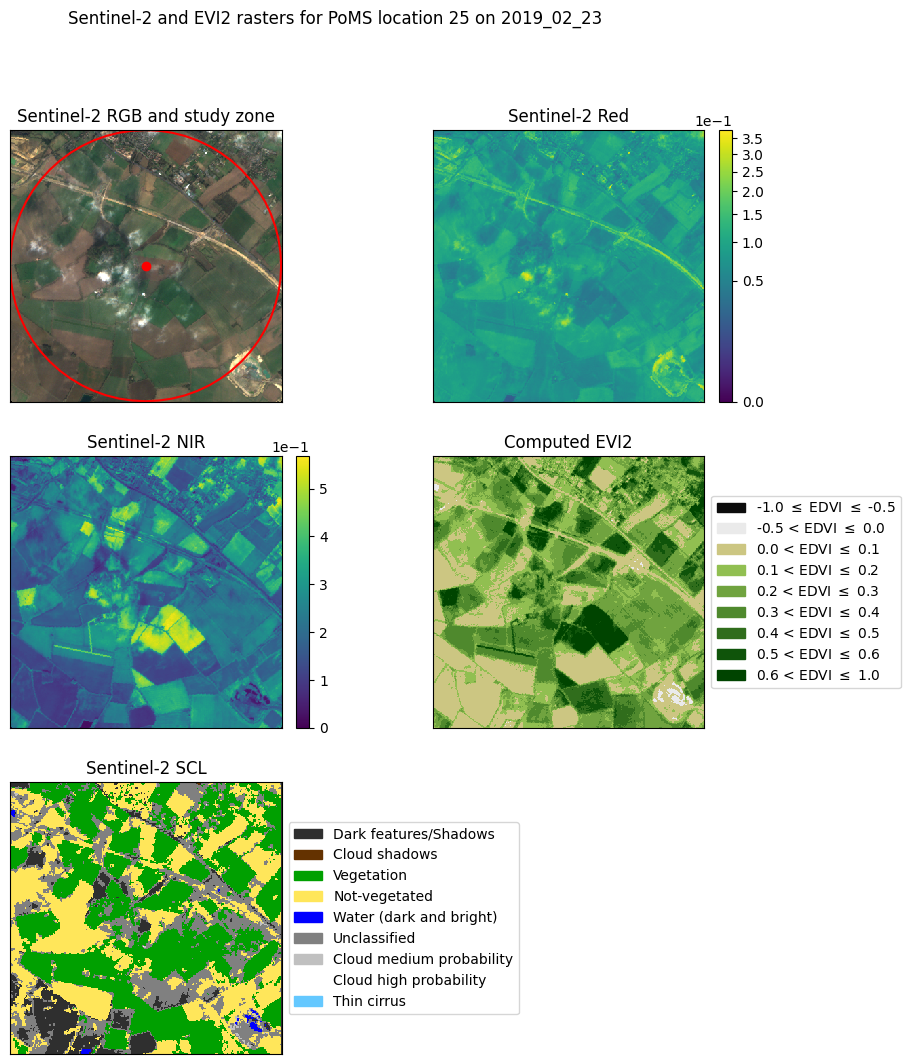

In [20]:
# Colormap as defined at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
edvi_ranges = ['-1.0 $\leq$ EDVI $\leq$ -0.5',
               '-0.5 < EDVI $\leq$ 0.0',
               '0.0 < EDVI $\leq$ 0.1',
               '0.1 < EDVI $\leq$ 0.2',
               '0.2 < EDVI $\leq$ 0.3',
               '0.3 < EDVI $\leq$ 0.4',
               '0.4 < EDVI $\leq$ 0.5',
               '0.5 < EDVI $\leq$ 0.6',
               '0.6 < EDVI $\leq$ 1.0'
              ]

edvi_ranges_nums =  [-1.0, -0.5, 0.0,
                                    0.1,
                                    0.2,
                                    0.3,
                                    0.4,
                                    0.5,
                                    0.6,
                                    1.0]
edvi_colors = [[i/255 for i in [12, 12, 12]],
                        [i/255 for i in [234, 234, 234]],
                        [i/255 for i in [204, 198, 130]],
                        [i/255 for i in [145, 191, 81]],
                        [i/255 for i in [112, 163, 63]],
                        [i/255 for i in [79, 137, 45]],
                        [i/255 for i in [48, 109, 28]],
                        [i/255 for i in [15, 84, 10]],
                        [i/255 for i in [0, 68, 0]]]


# Color mapping for the scene classification
# Color map as described at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

classification_names = ['Dark features/Shadows',
                        'Cloud shadows',
                        'Vegetation',
                        'Not-vegetated',
                        'Water (dark and bright)',
                        'Unclassified',
                        'Cloud medium probability',
                        'Cloud high probability',
                        'Thin cirrus']

classification_colors = [[i/255 for i in [47, 47, 47]],
                        [i/255 for i in [100, 50, 0]],
                        [i/255 for i in [0, 160, 0]],
                        [i/255 for i in [255, 230, 90]],
                        [i/255 for i in [0, 0, 255]],
                        [i/255 for i in [128, 128, 128]],
                        [i/255 for i in [192, 192, 192]],
                        [i/255 for i in [255, 255, 255]],
                        [i/255 for i in [100, 200, 255]]]

scl_cmap = mpl.colors.LinearSegmentedColormap.from_list('SCL map', classification_colors, len(classification_colors))
scl_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(classification_colors, 
                                                                                        classification_names)]
scl_norm = mpl.colors.BoundaryNorm([i - 0.5 for i in range(2, 12)], scl_cmap.N)



edvi_cmap = mpl.colors.LinearSegmentedColormap.from_list('EDVI map', edvi_colors, len(edvi_colors))
edvi_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(edvi_colors, edvi_ranges)]
edvi_norm = mpl.colors.BoundaryNorm(edvi_ranges_nums, edvi_cmap.N)


fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 12))
axs = axs.ravel()



views = ['visual', 'red', 'nir', 'evi2', 'scl']
titles = ['Sentinel-2 RGB and study zone', 'Sentinel-2 Red', 'Sentinel-2 NIR', 'Computed EVI2', 'Sentinel-2 SCL']
norms = [None, mpl.colors.PowerNorm(0.4), None, edvi_norm, scl_norm]
cmaps = [None, None, None, edvi_cmap, scl_cmap]

for i, view in enumerate(views):
    band_name = view
    with rasterio.open(os.path.join(DATA_BASE_PATH, f'location_{location_code}', date, view + '.tif')) as src:
        data_profile = {'data': src.read(), 'profile': src.profile}
        extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    
    ax = axs[i]
    if view in ['red', 'nir']:
        plot_data = data_profile['data'] / 10000 # Quantification value
    else:
        plot_data = data_profile['data']
        
    im = ax.imshow(np.squeeze(np.moveaxis(plot_data, 0, -1)), 
                   norm=norms[i],
                   cmap=cmaps[i], 
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                   extent=extent
                  )

    if view == 'visual':
        locations.loc[[location_code]].plot(ax=ax, color='red', label='PoMS study area centroid')
        locations.loc[[location_code]]['study_zone'].exterior.plot(ax=ax, label='study zone', 
                                                               color='red')
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], wrap=True)
    cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    if view == 'visual':
        cbar.ax.set_visible(False)
    elif view == 'scl':
        cbar.ax.set_visible(False)
        ax.legend(handles=scl_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
    elif view == 'evi2':
        cbar.ax.set_visible(False)
        ax.legend(handles=edvi_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
        

axs[-1].set_axis_off()
plt.suptitle('Sentinel-2 and EVI2 rasters for PoMS location {} on {}'.format(location_code, date))
plt.show()

### Productivity and phenology parameters calculations


Before executing a productivity and phenology analysis based on Sentinel-2 imagery, a mask to remove "bad" pixels is defined.

In this section, the process is demonstrated for one example location, before looping through all PoMS localities.

Note that in place of the more frequently used NDVI index, the authors of [6] use the EVI2 index as a vegetation index, citing deficiencies with NDVI in relation to this use case.

<br />
$$
  EVI2 = 2.5*\frac{NIR - RED}{NIR + 2.4*RED + 1}
$$
<br />

 


#### Example for one location and date

Define a mask to select only the study area from a raster:

In [21]:
def rasterize_geoms(geoms, profile):
    '''Rasterizes geometries (geoms) according to a raster spec (profile).'''
    mask = rasterio.features.rasterize(geoms, 
                                        out_shape=(int(profile['height']), int(profile['width'])),
                                        fill=0,
                                        transform=profile['transform'],
                                        default_value=1, 
                                        dtype='uint8').astype(bool)
    return mask

def get_study_area_mask(aoi_dir):
    '''Returns a mask for the study area for a given location'''
    id = int(aoi_dir.split('_')[1])

    # Refer to arable_samples_loc_yr_unique as a global, which is the source of AOI specific metadata here
    study_zone_geom = locations.loc[id, 'study_zone']

    # Use the EVI2 profile for rasterize op
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile

    return rasterize_geoms([study_zone_geom], evi2_profile)


Define a mask to remove bad pixels (according to Sentinel-2 scene classification):

In [22]:
def get_scl_good_mask(aoi_dir, date):
    '''Returns a mask that filters out "bad" pixels according to the S2 scene classification.'''
    scl_path = os.path.join(DATA_BASE_PATH, aoi_dir, date, 'scl.tif')
    scl_raw = rasterio.open(scl_path).read(1)
    scl_good_mask = ~np.isin(scl_raw, [0, # No data
                                       1, # Saturated/defective pixel
                                       6, # Water
                                       9, # Cloud high prob
                                       11]) # Snow or ice

    return scl_good_mask

Define a mask to identify pixels that are never vegetated according to the Sentinel-2 scene classification map: 

In [23]:
def get_scl_never_veg_mask(aoi_dir):
    '''Returns a mask that filters out pixels not labelled as vegetation according to S2 SCL for the entire period.'''
    def not_vegetated_mask(path):
        return rasterio.open(path).read(1) != 4

    base_path = os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'scl.tif')
    scl_never_veg = ~functools.reduce(np.logical_and, [not_vegetated_mask(i) for i in glob(base_path)])

    return scl_never_veg



Now get masks based on CROME crop designation. The method was originally applied to spring cereals [6], so return a spring cereal mask.

In [24]:
def get_crome_series(aoi_dir):
    '''Returns a geometry series of CROME spring cereals and agricultural land for a given location.'''
    crome_path = os.path.join(DATA_BASE_PATH, aoi_dir, 'CROME')
    crome_data = gpd.read_file(crome_path)
    crome_sc_series = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry
    crome_ag_series = crome_data[crome_data['lucode'].str.startswith(('AC', 'CA', 'LG', 'NU', 'TC', 'SR'))].dissolve().explode().to_crs(WORKING_CRS).geometry
    
    return crome_sc_series, crome_ag_series


def get_farmed_area(aoi_dir):
    '''Reads CROME data and calculates the land area used for spring cereal culitvation and also (all types of) agriculture for this tile.'''
    spring_cereals, ag_series = get_crome_sc_series(aoi_dir)
    spring_cereal_area = spring_cereals.area.sum()
    agric_area = ag_series.area.sum()

    return spring_cereal_area, agric_area

def get_cereal_masks(aoi_dir):
    '''Gets cereal land-use masks based on CROME data.'''
    # For this location get CROME data (constant on a year)
    spring_cereal_geoms, _ = get_crome_series(aoi_dir).to_numpy()
    
    # Convert shapes to rasters based on raster profile of an evi2.tif for this location (should all have the same profile)
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile

    # Generate spring cereal mask
    cereal_mask = rasterize_geoms(spring_cereal_geoms, evi2_profile)

    return cereal_mask



Apply masks to demo datapoint (single date in the timeseries) to show masking effect. Note that the composite mask is an intersection between the spring cereal mask, the study area mask and the Sentinel-2 scene classification mask (not never vegetated).

In [ ]:
# Include the AOI mask and never_veg in the cereal mask for compactness
cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)

# Define relevant Xarray variables
evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()

# Create masks (date-specific) based on SCL good pixels
good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                 coords=evi2_xr.coords,
                                  dims=('time', 'y', 'x'))

# Masks at a given timestep are then given as
# xr.where(cereal_mask, xr.where(good_scl_masks_xr, 1, 0), 0).isel(time=0)

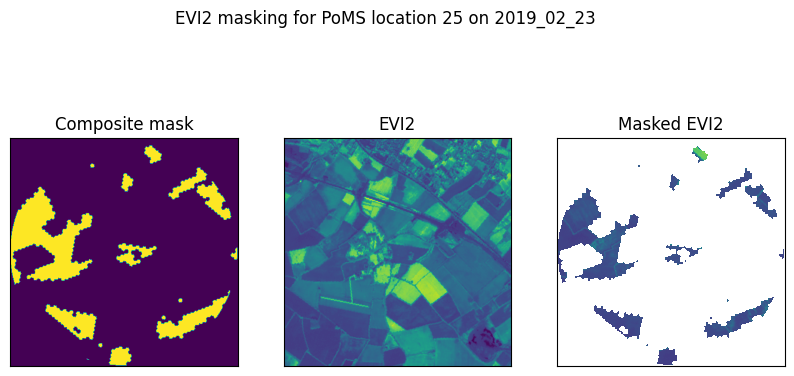

In [ ]:
# Used chained where condition

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(xr.where(cereal_mask, xr.where(good_scl_masks_xr, 1, 0), 0).isel(time=0))
ax.set_title('Composite mask')

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))
ax.set_title('EVI2')

ax = axs[2]
ax.imshow(xr.where(cereal_mask, 
                      xr.where(good_scl_masks_xr, 
                               evi2_xr, 
                               np.nan), 
             np.nan).isel(time=0), interpolation=None, vmin=evi2_xr.isel(time=0).min(), vmax=evi2_xr.isel(time=0).max())
ax.set_title('Masked EVI2')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.suptitle("EVI2 masking for PoMS location {} on {}".format(aoi_dir.split('_')[1], date))
plt.show()

#### Time-series analysis for S2-based phenology and productivity parameters

It is now possible to calculate phenology and productivity parameters, based on the timeseries of masked vegetation indices.

The following shows the approach for a single PoMS location, using Python distributions of Xarray, and PhenoloPy. The analysis process shown here follows a PhenoloPy tutorial for a similar use case [12].

Note that several minor fixes to my local PhenoloPy functions were necessary for usage with the newer Xarray and NumPy releases used in this environment.

In [26]:
# Mask the EVI2 dataset
evi2_cereal_xr = xr.where(cereal_mask, 
                                  xr.where(good_scl_masks_xr, 
                                           evi2_xr, 
                                           np.nan), 
                          np.nan)

# Just do a bit of xarray preparation
evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})

# Redefine as a dataset
evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})

Now for the productivity/phenology calculation routine:

In [27]:
evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)

Group dataset interval: month via reducer: median
> Selecting year: 2019 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.



In [28]:
evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2)

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



In [29]:
# set resample interval now, as a few functions require it
interval = '2W'
evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.



In [30]:
evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking and removing non-dominant year often introduced following resampling.
> More than one year detected in dataset. Removal non-dominant years.
> Checked and removed non-dominant year (if needed) successfully.


In [31]:
evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



In [32]:
result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of fifth percentile veg index (bse_fifth_per) values.
> Calculating fifth percentile veg index (bse_fifth_per) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning addition of CRS metadata.
> Adding CRS metadata.
> Could not add CRS metadata to data. Aborting.

Phenometrics calculated successfully!


Amplitude of Season (AOS) of the vegetation index is defined as the peak value (max observed in the season) minus the base value (fifth percentile of vegetation index) and was found to have the strongest correlation with farmer reported yields and biodiversity metrics, alongside peak EVI2 [6].

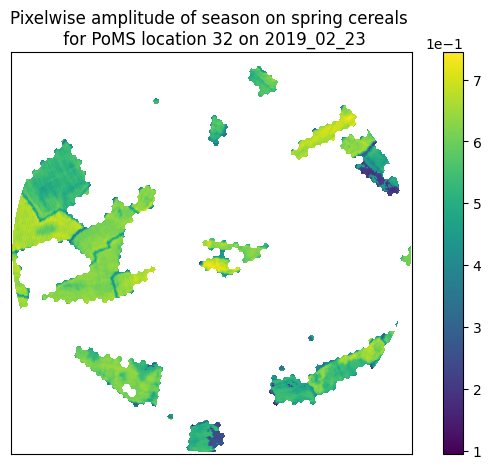

In [37]:
plt.figure()
plt.imshow(result.isel(phen_metric=2).to_numpy())
plt.title("Pixelwise amplitude of season on spring cereals \n for PoMS location {} on {}".format(aoi_dir.split('_')[1], date))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

With reference to the EVI2 timeseries and amplitude distributions for pixels labelled spring cereal according to CROME, the pixel-wise EVI2 time series for this location clearly shows that despite a bimodal amplitude distribution, the majority of pixels exhibit a similar peak in the early summer period.

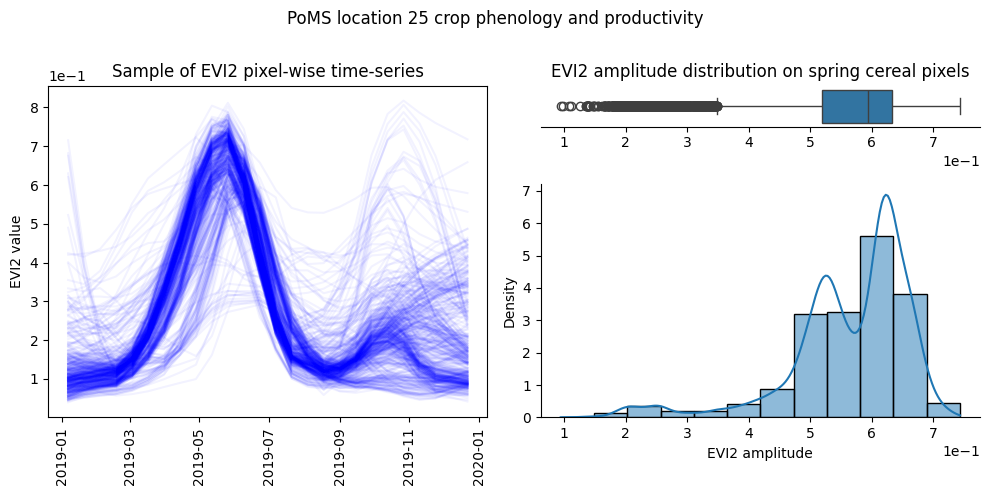

In [34]:
non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

# Create 2x2 sub plots
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=(.15, .85))

plt.figure(figsize=(10, 5))

ax = plt.subplot(gs[:, 0]) 
for pixel_ref in range(0, veg_index_timeseries.shape[1], 50):
    ax.plot(evi2_cereal_xr.time, veg_index_timeseries[:, pixel_ref], color='b', alpha=0.05)
ax.set_title('Sample of EVI2 pixel-wise time-series')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('EVI2 value')

_ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.boxplot(x=aos_vals, ax=_ax)
_ax.set(yticks=[])
sns.despine(ax=_ax, left=True)
_ax.set_title('EVI2 amplitude distribution on spring cereal pixels')

ax = plt.subplot(gs[1, 1]) 
ax.sharex(_ax)
sns.histplot(x=aos_vals, bins=12, kde=True, stat='density', ax=ax)
sns.despine(ax=ax)
ax.set_xlabel('EVI2 amplitude')

plt.suptitle("PoMS location {} crop phenology and productivity".format(aoi_dir.split('_')[1]))
plt.tight_layout()
plt.show()



The above method is now applied to the remaining PoMS locations, and the median AOS across all spring cereal pixels is recorded for each site.

Expand the cell below for the implementation.

In [ ]:
def get_aos(aoi_dir):
    '''Returns the median evi2 amplitude on spring cereal fields in AOI'''
    distributed_print(f'Beginning processing for {aoi_dir}')
    
    # Get static mask (independent of time) - sometimes there is no geometry to rasterize
    try:
        cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)
        spring_cereal_area, agric_area = get_farmed_area(aoi_dir)
        spr_cer_per = 100*spring_cereal_area/agric_area
        assert spr_cer_per > 5.0, "Spring cereal fields as percentage of farmed area less than threshold (5%), skipping"
    except Exception as e:
        distributed_print((aoi_dir, e))
        return aoi_dir, None
        
    # Define relevant Xarray variables
    evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
    dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
    evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()
    
    # Create masks (date-specific) based on SCL good pixels
    good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                     coords=evi2_xr.coords,
                                      dims=('time', 'y', 'x'))

    # Mask the EVI2 dataset
    evi2_cereal_xr = xr.where(cereal_mask, 
                                      xr.where(good_scl_masks_xr, 
                                               evi2_xr, 
                                               np.nan), 
                              np.nan)

    # Now for the phenology and productivity calculations
    # Just do a bit of xarray preparation
    evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
    evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})
    evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
    evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})
    evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2, z_pval=0.05)
    interval = '2W'
    evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
    evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')
    evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
    evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

    result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

    non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
    veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
    aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

    distributed_print(f'Done processing {aoi_dir}')

    return aoi_dir, np.median(aos_vals)

results = []
aoi_dirs = [i for i in os.listdir(DATA_BASE_PATH) if os.path.isdir(os.path.join(DATA_BASE_PATH, i)) and 'metadata.csv' in os.listdir(os.path.join(DATA_BASE_PATH, i))]
for aoi_dir in aoi_dirs:
    results.append(get_aos(aoi_dir))

results = pd.DataFrame(results, columns=['location', 'median_aos']).dropna()
results.to_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'))

## Results

Comparing the Sentinel-2 derived median AOS figures against modelled biodiversity metrics, no significant correlation is observed for either abundance or species richness. This contrasts with the findings of [6], in which significant correlations were reported for biodiversity metrics (and farmer reported yields, not analysed here), and is discussed in the following section.

In [73]:
aos_vals = pd.read_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'), index_col=0)
aos_vals['location_code'] = aos_vals['location'].str.split('_').str[1].astype(int)
aos_vals.set_index('location_code', inplace=True)

In [74]:
bio_aos = pd.merge(aos_vals, bee_hoverfly_biodiversity, left_index=True, right_index=True, how='left')
bio_aos.sort_values('median_aos').head()

,location,median_aos,abundance_1,species_richness_1
location_code,,,,
94,location_94,0.271053,3.461538,2.538462
1,location_1,0.290002,8.833333,4.166667
34,location_34,0.309578,5.166667,3.444444
79,location_79,0.360096,2.333333,1.777778
5,location_5,0.400586,4.187500,2.750000


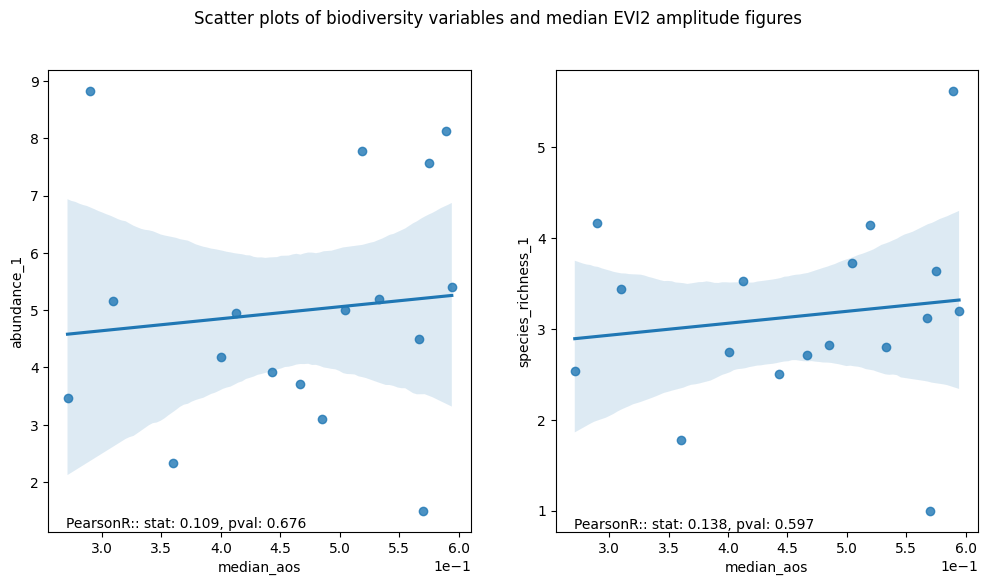

In [75]:

fig, axs = plt.subplots(1, 2, figsize=(12,6))

sns.regplot(x='median_aos',y='abundance_1', data=bio_aos,fit_reg=True, ax=axs[0]) 
sns.regplot(x='median_aos',y='species_richness_1', data=bio_aos,fit_reg=True, ax=axs[1])

axs[0].text(0.27, 1.2, 'PearsonR:: stat: {}, pval: {}'.format(round(pearsonr(bio_aos['median_aos'], bio_aos['abundance_1']).statistic, 3),
                                                              round(pearsonr(bio_aos['median_aos'], bio_aos['abundance_1']).pvalue, 3)))

axs[1].text(0.27, 0.8, 'PearsonR:: stat: {}, pval: {}'.format(round(pearsonr(bio_aos['median_aos'], bio_aos['species_richness_1']).statistic, 3),
                                                              round(pearsonr(bio_aos['median_aos'], bio_aos['species_richness_1']).pvalue, 3)))

plt.suptitle('Scatter plots of biodiversity variables and median EVI2 amplitude figures')
plt.show()

## Discussion and conclusions


As observed in the results section, a significant correlation between Sentinel-2 derived productivity parameters and pollinator biodiversity metrics as observed by the authors of [6] was not reproduced in this study. There are a number of possible explanations for this result, which are discussed in this section.

The methodology applied in this study constitutes an adaptation of that presented in [6], for use with the PoMS dataset, as described in the methodology section. Notably, Sentinel-2 derived parameters are calculated on a 2km radius zone around the PoMS study location here; therefore aiming to proxy agricultural intensity in the surrounding area for each PoMS location, instead of taking the immediate vicinity as in the original study [6]. The assumptions are that firstly pollinators are mobile within a distance greater than the study area use here, and secondly, surrounding spring cereal remote sensing-derived productivity parameters can effectively proxy agricultural intensity and hence would correlate (negatively) with biodiversity metrics.

Assessing the reliability of the first of those assumptions in further detail is out of the scope of this study, though the literature would suggest that is is not unreasonable (as discussed earlier in the methodology).

On the second assumption, it is possible that correlations observed at small spatial scales as in [6] do not translate to statistics based on the surrounding area at each PoMS location, the effects being too weak to discernibly influence biodiversity metrics. Indeed spring cereal fields represent just one element of the agricultural environment surrounding each PoMS sampling location. Combined with a relatively small sample size, and limitations with the resolution of the CROME dataset which causes Sentinel-2 grid pixels to be incorrectly labelled spring cereal on resampling, it would be incorrect to call into question the repeatability of the methodology presented in [6] based on the findings documented in this notebook.

Further research should focus on the following topics:
1. Derivation of remote sensing agricultural intensity proxies based on other crop types, which would allow greater generalisation of the type of analysis explored here.
2. Direct comparison of remote sensing derived parameters against agricultural intensity data for broader validation of the methodology: for instance, large-scale spatial datasets of artificial agricultural input rates exist (though are not open access), see the UKCEH's "Land Cover plus: Fertilisers and Pesticides" product as an example.
3. Replication of the methodology presented in this notebook, maintaining greater fidelity to that presented by the authors of [6], particularly in relation to spatial scales.


The next notebook in this series will focus on the third point, performing a similar analysis on much smaller study locations, which is possible because of the larger pool of sampling locations used for the UK's National Plant Monitoring Scheme.


## References

1. Phillips H, De Palma A, Gonzalez RE, Contu S et al. The Biodiversity Intactness Index - Country, Region and Global-Level Summaries for the Year 1970 to 2050 Under Various Scenarios (Data set). Natural History Museum. https://doi.org/10.5519/he1eqmg1
2. UK Department for Environment, Food and Rural Affairs (DEFRA). Agricultural Land Use in United Kingdom at 1 June 2023. Updated 14 December 2023. UK GOV website. https://www.gov.uk/government/statistics/agricultural-land-use-in-the-united-kingdom. 
3. Reidsma P, Tekelenburg T, van der Berg M, Alkemade R. Impacts of Land-Use Change on Biodiversity: An Assessment of Agricultural Biodiversity in the European Union. Agriculture, Ecosystems & Environment. 2006; 144(1): 86-102. https://doi.org/10.1016/j.agee.2005.11.026.
4. Robinson RA and Sutherland WJ. Post-war Changes in Arable Farming and Biodiversity in Great Britain. Journal of Applied Ecology. 2002. 39(1): 157-176. https://doi.org/10.1046/j.1365-2664.2002.00695.x.
5. Food and Agriculture Organization of the United Nations. Land, Inputs and Sustainability / Fertilizers by Nutrient. https://www.fao.org/faostat/en/#data/RFN.
6. Abdi AM, Carrié R, Sidemo-Holm W, Cai Z, Boke-Olén N, Smith HG, Eklundh L, Ekroos J, Biodiversity Decline With Increasing Crop Productivity in Agricultural Fields Revealed by Satellite Remote Sensing. Ecological Indicators. 2021; 130():108098. https://doi.org/10.1016/j.ecolind.2021.108098.
7. UK Pollinator Monitoring Scheme (2022). Pan-Trap Survey Data From the UK Pollinator Monitoring Scheme, 2017-2020 version 2 NERC EDS Environmental Information Data Centre. https://doi.org/10.5285/2c43ba3c-d821-442c-989b-754451d72091.
8. UK-SCAPE (UK Centre for Ecology and Hydrology). UK Pollinator Monitoring Scheme. https://uk-scape.ceh.ac.uk/our-science/projects/PoMS. [Accessed 20/02/2024].
9. Koellner T, Hersperger AM and Wohlgemuth T. Rarefaction Method for Assessing Plant Species Diversity on a Regional Scale. Ecography. 2004. 27(1): 532-544. https://doi.org/10.1111/j.0906-7590.2004.03832.x.
10. UK Rural Payments Agency (RPA). Crop Map of England (CROME), 2019. Licence: https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/.
11. Ribbands CR.The Flight Range of the Honey-Bee. Journal of Animal Ecology. 1951. 20(2); 220–226. https://doi.org/10.2307/1541.
13. Trotter L. PhenoloPy Tutorial. https://github.com/lewistrotter/PhenoloPy/blob/main/Phenolopy.ipynb.


